In [124]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf

In [125]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
print(nino34)
nino34 = np.array(nino34['nino34'].values)

<xarray.Dataset>
Dimensions:         (bounds: 2, month: 12, time: 7800)
Coordinates:
  * time            (time) float64 15.5 45.0 74.5 ... 2.372e+05 2.372e+05
Dimensions without coordinates: bounds, month
Data variables:
    nino34          (time) float64 ...
    time_bnds       (time, bounds) float64 ...
    areacello       float32 ...
    days_per_month  (month) int32 ...


[26.45655823 27.03681374 27.49559593 ... 25.17037201 25.43477631
 25.57539558]


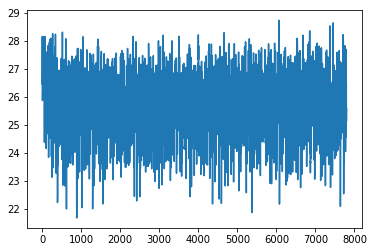

In [126]:
print(nino34)
plt.plot(nino34);

In [127]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

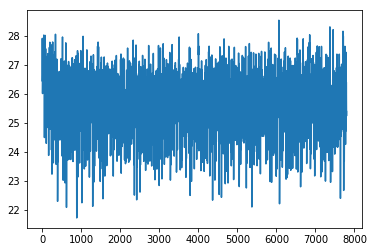

In [128]:
oni = ONI(nino34)
plt.plot(oni);

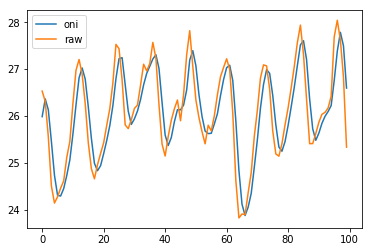

In [129]:
plt.plot(oni[100:200], label = "oni")
plt.plot(nino34[100:200], label = "raw")
plt.legend();

In [130]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

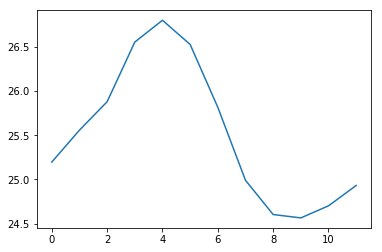

In [131]:
clm = climatology(nino34)
plt.plot(range(12), clm)
plt.show()

In [132]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [133]:
def rbplot(x, y, threshold=0.5):
    plt.plot(x, y, 'k')
    plt.plot([x[0],x[-1]], [0, 0], 'k--')
    plt.plot([x[0],x[-1]], [threshold, threshold], 'r--')
    plt.plot([x[0],x[-1]], [-threshold, -threshold], 'b--')
    plt.fill_between(x, threshold, y, color='red', where=y>=threshold, interpolate=True)
    plt.fill_between(x, -threshold, y, color='blue', where=y<=-threshold, interpolate=True)

(1950, 2020)

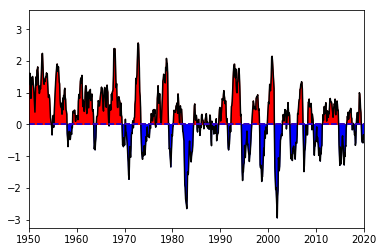

In [134]:
anm = SST_anomaly(nino34, clm)
length = nino34.shape[0]
rbplot(np.arange(length) / 12 + 1950, anm, threshold = 0)
plt.xlim(1950, 2020)

(1950, 2020)

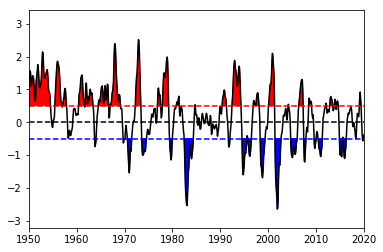

In [135]:
oanm = ONI(anm)
rbplot(np.arange(length) / 12 + 1950, oanm, threshold = 0.5)
plt.xlim(1950, 2020)

# Data Preparation

In [136]:
T = 6                       # prediction timeline
H = 48                      # history used for prediction
n_classes = 3               # number of classes (El Nino, El Nina, No Event)
threshold = 0.5         
signal = np.array(nino34)   # data used for training/testing
length = signal.shape[0]    # number of data points
size = length - H - T       # effective dataset size

In [137]:
# create the 'history matrix'
data = np.ndarray((size, H))
for i in range(size):
    data[i] = signal[i:(i + H)]

# label El Nino as 1, El Nina as -1 and no event as 0
labels = np.ndarray((size))
for i in range(length - H - T):
    if(oanm[i + H + T] >= threshold):
        labels[i] = 2
    elif(oanm[i + H + T] <= -threshold):
        labels[i] = 0
    else:
        labels[i] = 1
        
# labels = np.random.randint(3, size = size)

In [138]:
np.random.seed(0)

split = 9 * size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0:split])
test_ind = np.array(shuffle[(split + 1):size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])

# Normalization and Label One-Hot Encoding

In [139]:
mean = np.mean(train)
std = np.std(train)
train_n = (train - mean) / std
test_n = (test - mean) / std

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    encoded_train_labels = tf.one_hot(train_labels, depth = n_classes).eval()
    encoded_test_labels = tf.one_hot(test_labels, depth = n_classes).eval()

# Simple Classifiers

Note: Same results with normalized/unnormalized data

In [115]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state = 0)
clf.fit(train, train_labels)
acc_DecisionTree = clf.score(test, test_labels)

print(np.around(acc_DecisionTree * 100, decimals = 2), "%")

51.94 %


In [123]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 10, max_depth = 2, random_state=0)
clf.fit(train, train_labels)
acc_RandomForest = clf.score(test, test_labels)

print(np.around(acc_RandomForest * 100, decimals = 2), "%")

46.5 %


In [116]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(train, train_labels)
acc_LogisticRegression = clf.score(test, test_labels)

print(np.around(acc_LogisticRegression * 100, decimals = 2), "%")

56.74 %


In [117]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(train, train_labels)
acc_LDA = clf.score(test, test_labels)

print(np.around(acc_LDA * 100, decimals = 2), "%")

56.35 %


/Users/paulag/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


In [118]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 10)
clf.fit(train, train_labels)
acc_KNN = clf.score(test, test_labels)

print(np.around(acc_KNN * 100, decimals = 2), "%")

61.4 %


In [119]:
from sklearn import multiclass
from sklearn.svm import SVC

clf = multiclass.OneVsRestClassifier(SVC(kernel='rbf', random_state = 0))
clf.fit(train, train_labels)
acc_SVC = clf.score(test, test_labels)

print(np.around(acc_SVC * 100, decimals = 2), "%")

63.73 %


# A Very Simple Neural Network

In [193]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4*H, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4*H, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
])

model.reset_states()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_n, encoded_train_labels, epochs=25)
model.evaluate(test_n, encoded_test_labels)

Epoch 1/25
6971/6971 [==============================] - 2s 242us/step - loss: 0.9244 - acc: 0.5509
Epoch 2/25
6971/6971 [==============================] - 1s 93us/step - loss: 0.8556 - acc: 0.5900
Epoch 3/25
6971/6971 [==============================] - 1s 102us/step - loss: 0.8313 - acc: 0.5988
Epoch 4/25
6971/6971 [==============================] - 1s 117us/step - loss: 0.8031 - acc: 0.6164
Epoch 5/25
6971/6971 [==============================] - 1s 119us/step - loss: 0.7892 - acc: 0.6234
Epoch 6/25
6971/6971 [==============================] - 1s 121us/step - loss: 0.7738 - acc: 0.6331
Epoch 7/25
6971/6971 [==============================] - 1s 103us/step - loss: 0.7526 - acc: 0.6497
Epoch 8/25
6971/6971 [==============================] - 1s 99us/step - loss: 0.7363 - acc: 0.6605
Epoch 9/25
6971/6971 [==============================] - 1s 121us/step - loss: 0.7205 - acc: 0.6676
Epoch 10/25
6971/6971 [==============================] - 1s 108us/step - loss: 0.7044 - acc: 0.6815
Epoch 11/25

[0.7464158100675243, 0.6795865633845021]

# Simple Neural Network

In [194]:
learning_rate = 0.001
epochs = 25
batch_size = split // 697

tf.reset_default_graph()

In [195]:
def model(inputs, dropout_rate):
    full_1 = tf.contrib.layers.fully_connected(inputs, num_outputs = 4*H, activation_fn = tf.nn.relu)
    drop_1 = tf.layers.dropout(full_1, dropout_rate)
    full_2 = tf.contrib.layers.fully_connected(drop_1, num_outputs = 4*H, activation_fn = tf.nn.relu)
    drop_2 = tf.layers.dropout(full_2, dropout_rate)
    outputs = tf.contrib.layers.fully_connected(drop_2, num_outputs = n_classes, activation_fn = tf.nn.relu)
    return outputs

In [196]:
x = tf.placeholder(tf.float32, shape = (None, H), name = 'x')
y = tf.placeholder(tf.float32, shape = (None, n_classes), name = 'y')

logits = model(x, 0.2)

In [197]:
with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    
with tf.variable_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
with tf.variable_scope("accuracy"):
    correct = tf.equal(tf.argmax(logits, axis = 1), tf.argmax(y, axis = 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [198]:
loss_eval = []
acc = []
ex = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(epochs):
        
        shuffle_ind = np.random.permutation(split)
        
        for j in np.arange(train_n.shape[0] // batch_size):
            sess.run(optimizer, feed_dict={x: train_n[shuffle_ind[j * batch_size : (j + 1) * batch_size]],
                                           y: encoded_train_labels[shuffle_ind[j * batch_size : (j + 1) * batch_size]]})
            
        loss_eval_val, acc_val = sess.run([loss, accuracy], feed_dict={x: train_n, y: encoded_train_labels})
        loss_eval.append(loss_eval_val)
        acc.append(acc_val)
        print("Epoch %d, loss = %g, accuracy = %f" % (i + 1, loss_eval_val, acc_val))
            
    acc = sess.run(accuracy, feed_dict={x: test_n, y: encoded_test_labels})
    print("Test accuracy: %f" % acc)

Epoch 1, loss = 0.91111, accuracy = 0.562760
Epoch 2, loss = 0.8475, accuracy = 0.602496
Epoch 3, loss = 0.825953, accuracy = 0.606369
Epoch 4, loss = 0.783292, accuracy = 0.639363
Epoch 5, loss = 0.776806, accuracy = 0.640941
Epoch 6, loss = 0.754091, accuracy = 0.651270
Epoch 7, loss = 0.73726, accuracy = 0.660307
Epoch 8, loss = 0.715115, accuracy = 0.680390
Epoch 9, loss = 0.687406, accuracy = 0.687276
Epoch 10, loss = 0.663302, accuracy = 0.703486
Epoch 11, loss = 0.646105, accuracy = 0.707359
Epoch 12, loss = 0.610261, accuracy = 0.733467
Epoch 13, loss = 0.567274, accuracy = 0.757854
Epoch 14, loss = 0.552808, accuracy = 0.766461
Epoch 15, loss = 0.531967, accuracy = 0.777076
Epoch 16, loss = 0.525342, accuracy = 0.775212
Epoch 17, loss = 0.46636, accuracy = 0.811648
Epoch 18, loss = 0.46579, accuracy = 0.803185
Epoch 19, loss = 0.424707, accuracy = 0.830440
Epoch 20, loss = 0.420125, accuracy = 0.827571
Epoch 21, loss = 0.377683, accuracy = 0.852388
Epoch 22, loss = 0.354507, a